# **1. Location of the clusters of genes in A/B compartments and within TADs.**

The following steps are included in the analysis:

1.   Define initial variables and paths
2.   Create bedfile with promoters coordinates from gene coordinates
3.   Create bedfile with TADs coordinates in bins (bin 0 - bin 5)
4.   Intersect promoters coordinates with the bins of TADs
5.   Load in instances information about promoters: location in TAD and bin, A/B compartments
6.   Perform analysis of the distribution of promoters in bins of TADs and A/B Compartments
7.   Perform Chi-square test in the distribution of bins

In [ ]:
# Import packages and Drive

#!pip install hic-straw
# import hicstraw

from google.colab import drive
drive.mount('/content/drive')

!pip install pybedtools
!apt-get install bedtools
import pybedtools

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec

import itertools
import random
import time
import re

from types import MappingProxyType
from collections import Counter
import statistics
from scipy.stats import norm
from scipy.stats import kstest

# Import classes: Feature, Promoter and Contact
sys.path.append(classes_folder)
from Contact import Contact
from Promoter import Promoter

In [ ]:
def IntersectBedfiles(bedfile_1, bedfile_2, output_file):
  # Load bed files using py bedtools
  bed1 = pybedtools.BedTool(bedfile_1)
  bed2 = pybedtools.BedTool(bedfile_2)

  # Perform intersection with 'wo' option to see bp overlap
  intersected = bed1.intersect(bed2, wo=True)
  # Perform intersection with 'v' option to see the not intersected regions
  not_intersected = bed2.intersect(bed1, v=True)

  with open(output_file, 'w') as outputfile:

      # Write the header line
      header_line = f'tad_chr\tbin_start\tbin_end\ttad_ID\tpromoter_chr\tpromoter_start\tpromoter_end\
      \tpromoter_ID\tNone\tStrand\tbp_intersected\n'
      outputfile.write(header_line)

      # Append intersected (bins 1-5) and not intersected (bin 0) TADs-genes
      for interval in intersected:

          # A) Inside TADs promoters

          # TAD columns
          tad_chr, bin_start, bin_end, tad_id = interval[0], interval[1], interval[2], interval[3]
          # Feature columns
          prom_chr, prom_start, prom_end, prom_id, prom_strand = interval[4], int(interval[5]), int(interval[6]), interval[7], interval[9]
          # Base-pair intersected column
          bp_intersected = interval[10]

          # Get TAD start and end (boundaries)
          TAD_coord, bin = tad_id.split('_') # TAD4760000-6200000_Bin1

          TAD_start, TAD_end = TAD_coord.split('-')
          TAD_start = TAD_start[3:]
          TAD_start, TAD_end = int(TAD_start), int(TAD_end)

          # B) Within TAD boundary promoters: Bin 0
          if (prom_start <= TAD_start <= prom_end) or (prom_start <= TAD_end <= prom_end):
              bin = 'Bin0'
              tad_id = f'TAD{TAD_start}-{TAD_end}_Bin0'

          # Write line
          line = f'{tad_chr}\t{bin_start}\t{bin_end}\t{tad_id}\t{prom_chr}\t{prom_start}\t{prom_end}\t{prom_id}\t1\t{prom_strand}\t{bp_intersected}\n'
          outputfile.write(str(line))

      # C) Inter-TAD promoters: Bin 0
      for interval in not_intersected:
          line = '.\t.\t.\tBin0\t' + str(interval).strip('\n') + '\t.' + '\n'
          outputfile.write(line)

def LoadPromotersInTads(input_file):
  with open(input_file, 'r') as file:
      next(file)
      for line in file:
          columns = line.strip().split('\t')

          # Get promoter instance
          prom_id = columns[7]
          prom_instance = Promoter.all_promoters[prom_id]

          # Get tad instance if not in inter-TAD region
          if columns[3] == 'Bin0':
              tad_instance, bin = 'Bin0', 'Bin0'
          else:
              tad_chr = columns[0]
              tad_coord, bin = columns[3].split('_')
              tad_instance = Tad.all_tads[tad_chr][tad_coord]
              tad_instance.LoadPromoter(prom_instance, bin)

          prom_instance.LoadTad(tad_instance, bin)

In [ ]:
drive_folder = "/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts"

# Data dirs and file
data_dir = drive_folder + "/data/"
tads_compartments_file = data_dir + "Bonev2017_TADs_Compartments.bed"
hk_genes_list = data_dir + "HK_genes_list.txt"

# Results dirs
results_dir = drive_folder + "/results/"
promoters_dir = drive_folder + "/results" + "/promoters_coord/"
part1_dir = drive_folder + "/results" + "/1.TADs_Compartments_Analysis/"
part1_logs = part1_dir + 'logs/'

# Create folders if do not exist
CreateFolder(results_dir)
CreateFolder(promoters_dir)
CreateFolder(part1_dir)
CreateFolder(part1_logs)

**1. Define initial variables and paths**

In [ ]:
# Set genome chromosomes
chromosomes = [f'chr{i}' for i in range(1, 20)] + ['chrX'] + ['chrY']
Promoter.chromosomes = chromosomes
clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3', 'cluster1']
Promoter.cluster_members = {cluster: [] for cluster in clusters}

Tad.chromosomes = chromosomes
# Initialize all_tads variable
Tad.all_tads = {chromosome: {} for chromosome in chromosomes}
# Set bins in TADs
Tad.bins = ['Bin0', 'Bin1', 'Bin2', 'Bin3', 'Bin4', 'Bin5']
# Get cluster dictionary with genes coord files
cluster_pattern = r"_([^_]*)cluster([^_]*)_"
clusters_dict = GetClusterNames(data_dir, cluster_pattern)
clusters_dict

{'cluster1A': 'All_genes_cluster1A_coords.bed',
 'cluster1B': 'All_genes_cluster1B_coords.bed',
 'cluster2': 'All_genes_cluster2_coords.bed',
 'cluster3': 'All_genes_cluster3_coords.bed'}

**2. Create bedfile with promoters coordinates from gene coordinates**

In [ ]:
# Create PROMOTERS COORD CLUSTER BEDFILES
window_for_TSS = 500
for cluster, cluster_file in clusters_dict.items():
    input_file =  data_dir + cluster_file
    output_file = promoters_dir + cluster_file.replace('genes', 'promoters')
    # Update clusters_dict
    clusters_dict[cluster] = cluster_file.replace('genes', 'promoters')
    if os.path.exists(output_file):
      print(f'{output_file} already exists and does not have to be created')
    else:
      CreatePromotersFile(input_file, output_file, window_for_TSS)
print('\n clusters_dict has been modified to work with promoters', clusters_dict, '\n')

# Create EVERY PROMOTERS COORD BEDFILE
output_file = os.path.join(promoters_dir, "All_promoters_coord.bed")
if os.path.exists(output_file):
    print(f'{output_file} already exists and does not have to be created\n')
else:
    with open(output_file, 'a') as outputfile:
        files_to_concatenate = os.listdir(promoters_dir)[:4]  # Get the first 4 files
        for file_name in files_to_concatenate:
            file_path = os.path.join(promoters_dir, file_name)
            with open(file_path, 'r') as inputfile:
                for line in inputfile:
                    outputfile.write(line)

/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_promoters_cluster1A_coords.bed already exists and does not have to be created
/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_promoters_cluster1B_coords.bed already exists and does not have to be created
/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_promoters_cluster2_coords.bed already exists and does not have to be created
/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_promoters_cluster3_coords.bed already exists and does not have to be created

 clusters_dict has been modified to work with promoters {'cluster1A': 'All_promoters_cluster1A_coords.bed', 'cluster1B': 'All_promoters_cluster1B_coords.bed', 'cluster2': 'All_promoters_cluster2_coords.bed', 'cluster3': 'All_promoters_cluster3_coords.bed'} 

/content/drive/My Drive/Miguel_TFM/TFM_definitive_scripts/results/promoters_coord/All_

**3.   Create bedfile with TADs coordinates in bins (bin 0-bin 5)**

In [ ]:
# Create BINNED TADs and COMPARTMENTS COORD FILE
n_bins = 5
output_file = part1_logs + "Bonev2017_TADs_Compartments_binned.bed"
if os.path.exists(output_file):
    print(f'{output_file} already exists and does not have to be create\n')
else:
  bins_vector = CreateBinsVector(n_bins)
  CreateBinsInTADs(bins_vector, tads_compartments_file, output_file)

**4.   Intersect promoters coordinates with the bins of TADs**

In [ ]:
# Create TADs/Compartments and promoters INTERSECTED FILE

bedfile1 = os.path.join(part1_logs, "Bonev2017_TADs_Compartments_binned.bed")
bedfile2 = os.path.join(promoters_dir, "All_promoters_coord.bed")
output_file = os.path.join(part1_logs, "promoters_TADsCompartments_intersection.txt")
if os.path.exists(output_file):
      print(f'{output_file} already exists and does not have to be created\n')
else:
  IntersectBedfiles(bedfile1, bedfile2, output_file)

**5.   Load in instances the information related to promoters: location in TAD and bin, A/B compartments**

In [ ]:
# Load promoters instances
for cluster, cluster_file in clusters_dict.items():
  bedfile = os.path.join(promoters_dir, cluster_file)
  Promoter.LoadFromBedfile(bedfile, cluster)

# Load TADs instances
bedfile = os.path.join(data_dir, "Bonev2017_TADs_Compartments.bed")
Tad.LoadFromBedfile(bedfile)

# Load promoters in TADs
inputfile = os.path.join(part1_logs, "promoters_TADsCompartments_intersection.txt")
LoadPromotersInTads(inputfile)

**6.   Perform analysis of the distribution of promoters in bins of TADs and A/B Compartments**

6.1. Calculate the distribution in A/B compartments

In [ ]:
def DividePromotersInCompartments(all_tads):
  # Divide tads in CompA and CompB
  compA_tads = [tad for tad in all_tads if tad.compartment == 'A']
  compB_tads = [tad for tad in all_tads if tad.compartment == 'B']

  # Promoters in CompA
  compA_promoters = []
  for tad in compA_tads:
    promoters = tad.RetrievePromoters()
    compA_promoters.extend([prom.identifier for prom in promoters if prom.identifier not in compA_promoters])
    compA_promoters = list(set(compA_promoters))


  # Promoters in CompB
  compB_promoters = []
  for tad in compB_tads:
    promoters = tad.RetrievePromoters()
    compB_promoters.extend([prom.identifier for prom in promoters if prom.identifier not in compB_promoters])
    compB_promoters = list(set(compB_promoters))

  # Promoters in both CompAB: None of them
  comp_AB_promoters = [identifier for identifier in compA_promoters if identifier in compB_promoters]

  # Promoters in Unassigned Comp (no intersection in TADs)
  all_promoters = Promoter.all_promoters.keys()
  assigned_promoters = compA_promoters + compB_promoters
  comp_unassigned_promoters = [identifier for identifier in all_promoters if identifier not in assigned_promoters]

  return compA_promoters, compB_promoters, comp_AB_promoters, comp_unassigned_promoters

def CalculateCompartmentsDistribution(df, clusters):
  for cluster in clusters:
    row_dict = {key : 0 for key in columns}
    if cluster == 'cluster1':
        cluster_promoters = Promoter.RetrieveClusterMembers('cluster1A') + Promoter.RetrieveClusterMembers('cluster1B')
    else:
      cluster_promoters = Promoter.RetrieveClusterMembers(cluster)
    cluster_identifiers = [prom.identifier for prom in cluster_promoters]
    row_dict['CompA'] = len(set(compA_promoters).intersection(cluster_identifiers))
    row_dict['CompB'] = len(set(compB_promoters).intersection(cluster_identifiers))
    row_dict['Unassigned'] = len(set(comp_unassigned_promoters).intersection(cluster_identifiers))
    total_counts = sum(row_dict.values())
    percentages_dict = {key: value / total_counts for key, value in row_dict.items()}
    formated_dict = {key: float("{:.2f}".format(value * 100)) for key, value in percentages_dict.items()}
    formated_dict['Cluster'] = cluster

    df_comps.loc[len(df_comps)] = formated_dict
  return df

In [ ]:
hk_identifiers = []
with open(hk_genes_list, 'r') as file:
  for line in file:
    identifier = line.strip('\n')
    hk_identifiers.append(identifier)

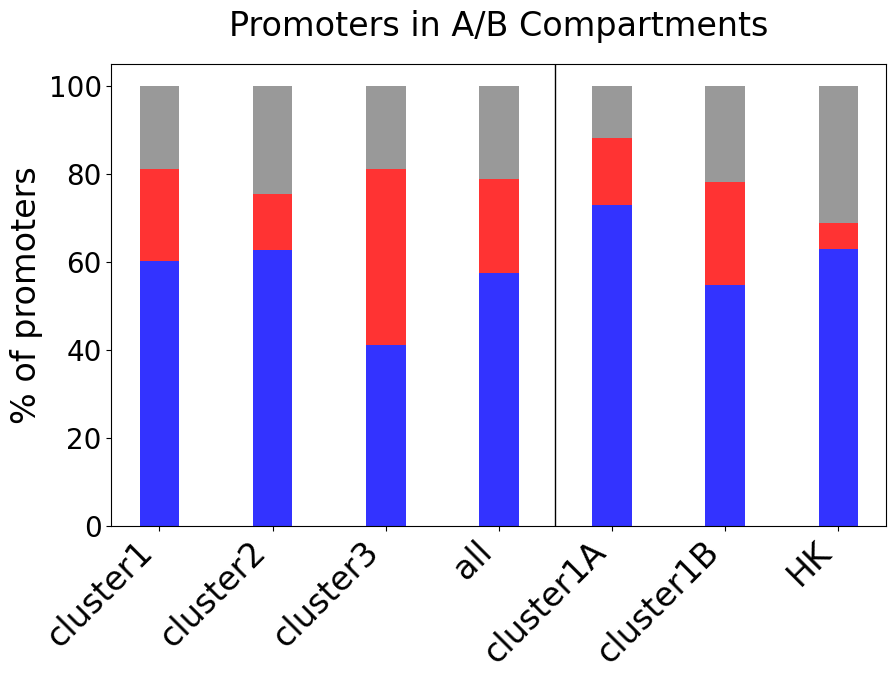

In [ ]:
csv_path = part1_logs + 'compartments_distribution.csv'
read_flag = False
if os.path.exists(csv_path):
    df_comps = pd.read_csv(csv_path)

else:
  # Divide promoters in Compartments
  all_tads = Tad.RetrieveAllTads()
  compA_promoters, compB_promoters, comp_AB_promoters, comp_unassigned_promoters = DividePromotersInCompartments(all_tads)

  # Calculate distribution for each cluster
  clusters = ['cluster1', 'cluster2', 'cluster3', 'all', 'cluster1A', 'cluster1B']
  columns = ['Cluster', 'CompA', 'CompB', 'Unassigned', 'Both']
  df_comps = pd.DataFrame(columns=columns)
  df_comps = CalculateCompartmentsDistribution(df_comps, clusters)

  # Add HK genes compartments
  cluster = 'HK'
  row_dict = {key : 0 for key in columns}
  row_dict['CompA'] = len(set(compA_promoters).intersection(hk_identifiers))
  row_dict['CompB'] = len(set(compB_promoters).intersection(hk_identifiers))
  row_dict['Unassigned'] = len(set(comp_unassigned_promoters).intersection(hk_identifiers))
  total_counts = sum(row_dict.values())
  percentages_dict = {key: value / total_counts for key, value in row_dict.items()}
  formated_dict = {key: float("{:.2f}".format(value * 100)) for key, value in percentages_dict.items()}
  formated_dict['Cluster'] = cluster
  df_comps.loc[len(df_comps)] = formated_dict

  df_comps.to_csv(csv_path, index=False)

def PlotCompartmentsDistribution(df_comps, png_path):

  size = 24
  size_smaller = size - 4

  # Plotting with thinner bars and different colors
  ax = df_comps.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.35,
                    color=['blue', 'red', 'gray'], alpha=0.8, legend=None)
  ax.set_ylabel('% of promoters', fontsize=size)
  ax.set_title('Promoters in A/B Compartments', fontsize=size, pad=20)  # Increase pad for more space between title and figure

  # Remove x-label
  ax.set_xlabel('')
  #plt.legend(loc='upper right', bbox_to_anchor=(1.37, 1), fontsize=size - 4)
  plt.xticks(rotation=45, ha='right')
  plt.yticks(fontsize=size)
  ax.tick_params(axis='x', labelsize=size)  # Adjust x-axis label size here
  ax.tick_params(axis='y', labelsize=size_smaller)  # Adjust x-axis label size here

  # Add horizontal lines
  #for value in [20, 40, 60, 80]:
  #    ax.axhline(y=value, color='black', linestyle='--', linewidth=0.5, alpha=0.6)

  # Add vertical line
  cluster1A_index = df_comps.index.get_loc('cluster1A')

  ax.axvline(x=cluster1A_index - 0.5, color='black', linestyle='-', linewidth=1.0)

  plt.savefig(png_path, bbox_inches='tight')  # Use bbox_inches='tight' to include legend properly
  #plt.savefig(png_path, bbox_inches='tight',  pad_inches=0.25)  # Use bbox_inches='tight' to include legend properly
  plt.show()

# Plot distributions
df_comps = df_comps.drop(columns='Both')
df_comps.set_index('Cluster', inplace=True)
png_path = part1_dir + 'compartments_distribution.png'
PlotCompartmentsDistribution(df_comps, png_path)

6.2. Calculate the distribution in bins

In [ ]:
def CalculateBinsDistribution(promoters, cluster, df):
  #Define counts of promoters in each bin
  total_bin_counts = {f'Bin{i}': 0 for i in range(n_bins + 1)}
  for promoter in promoters:
    # Bins of promoters
    promoter_bins = [value for sublist in promoter.tads.values() for value in sublist]
    # Bins are counted once in the TAD
    unique_bins = list(set(promoter_bins))

    # Bin 0 will only count for once)
    if 'Bin0' in unique_bins:
        total_bin_counts['Bin0'] += 1
    else:
        for bin in unique_bins:
            total_bin_counts[bin] += 1
  # Get total counts
  total_counts = sum(value for value in total_bin_counts.values())
  # Bin percentages
  percentages_dict = {key: value / total_counts for key, value in total_bin_counts.items()}
  formated_dict = {key: float("{:.2f}".format(value * 100)) for key, value in percentages_dict.items()}
  # Save in df
  formated_dict['Cluster'] = cluster
  formated_dict['permutation'] = permutation
  new_row = formated_dict
  df.loc[len(df)] = new_row
  return df

In [ ]:
# Distribution of promoters in the bins of TADs - REAL clusters

csv_path = part1_logs + 'bins_distribution_observed.csv'
permutation = 'Observed'

if os.path.exists(csv_path):
  df_observed = pd.read_csv(csv_path)
else:
  columns = ['permutation', 'Cluster'] + Tad.bins
  df = pd.DataFrame(columns=columns)

  # Cluster1 distribution
  cluster = 'cluster1'
  promoters = Promoter.RetrieveClusterMembers('cluster1A') + Promoter.RetrieveClusterMembers('cluster1B')
  df = CalculateBinsDistribution(promoters, cluster, df)

  # Clusters 1A, 1B, 2, 3 distribution
  for cluster in clusters_dict.keys():
    promoters = Promoter.RetrieveClusterMembers(cluster)
    df = CalculateBinsDistribution(promoters, cluster, df)

  # 'All' promoters distribution
  cluster = 'all'
  promoters = Promoter.RetrieveClusterMembers(cluster)
  df = CalculateBinsDistribution(promoters, cluster, df)

  # HK genes distribution
  cluster = 'HK'
  hk_identifiers = []
  with open(hk_genes_list, 'r') as file:
    for line in file:
      identifier = line.strip('\n')
      hk_identifiers.append(identifier)
  hk_promoters = []
  for identifier, promoter in Promoter.all_promoters.items():
    if identifier in hk_identifiers:
      hk_promoters.append(promoter)
  df = CalculateBinsDistribution(hk_promoters, cluster, df)

  # Make a little modification in column names
  df = df.rename(columns={col: str(i) for i, col in enumerate(df.columns[2:], start=0)})

  df_observed = df.copy()
  df_observed.to_csv(csv_path, index=False)

df_observed

,permutation,Cluster,0,1,2,3,4,5
0,Observed,cluster1,19.13,17.42,16.37,16.78,15.63,14.67
1,Observed,cluster1A,12.20,18.21,17.06,18.06,17.71,16.76
2,Observed,cluster1B,22.12,17.07,16.07,16.23,14.73,13.78
3,Observed,cluster2,24.86,17.24,14.95,14.07,14.19,14.69
4,Observed,cluster3,19.21,16.84,17.55,15.91,14.98,15.52
5,Observed,all,21.37,17.23,16.05,15.56,14.94,14.85
6,Observed,HK,31.61,15.49,13.67,12.76,12.79,13.67


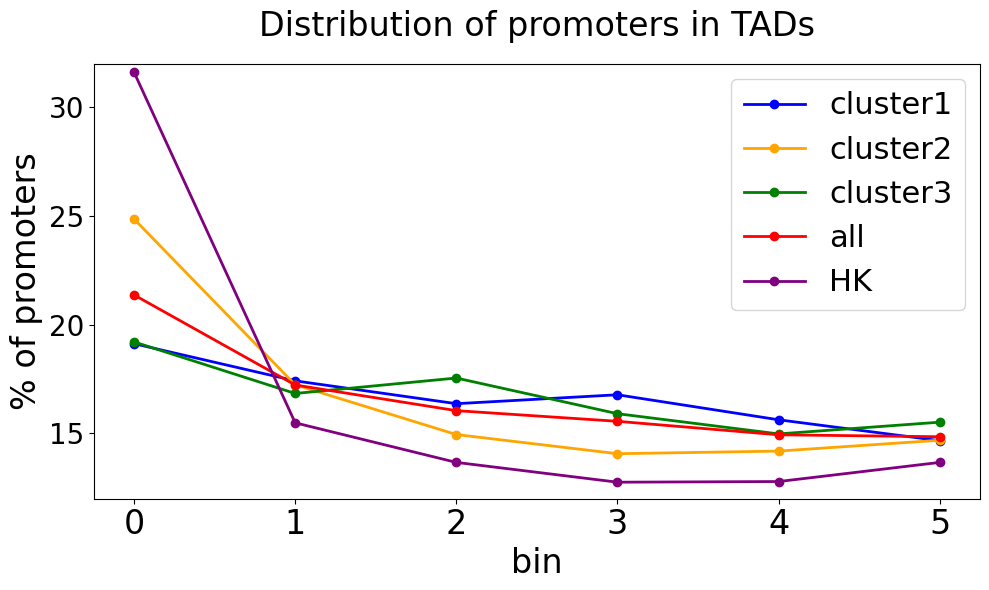

In [ ]:
def PlotBinsDistribution(df, colors, png_path):
    # Plot
    plt.figure(figsize=(10, 6))

    size = 24
    size_smaller = size - 4
    # Plot each cluster
    for index, row in df.iterrows():
        plt.plot(df.columns[2:], row[2:], marker='o', color=colors[row['Cluster']], label=row['Cluster'], linewidth=2, markersize=6)

    # Add labels and legend
    plt.xlabel('bin', fontsize = size)
    plt.ylabel('% of promoters', fontsize = size)
    plt.title('Distribution of promoters in TADs', fontsize=size, pad=20)
    #plt.xticks(rotation=45)
    plt.legend()
    plt.ylim(12, 32)  # Adjust limits as needed
    plt.yticks([15, 20, 25, 30], fontsize=size_smaller)
    plt.xticks(fontsize=size)
    plt.legend(fontsize=size - 2)  # Increase font size of legend

    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(png_path)
    plt.show()

colors = {'cluster1' : 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all' : 'red', 'HK' : 'purple'}
png_path = part1_dir + 'distribution_bins.png'

PlotBinsDistribution(df_observed[(df_observed['Cluster'] != 'cluster1A') & (df_observed['Cluster'] != 'cluster1B')], colors, png_path)

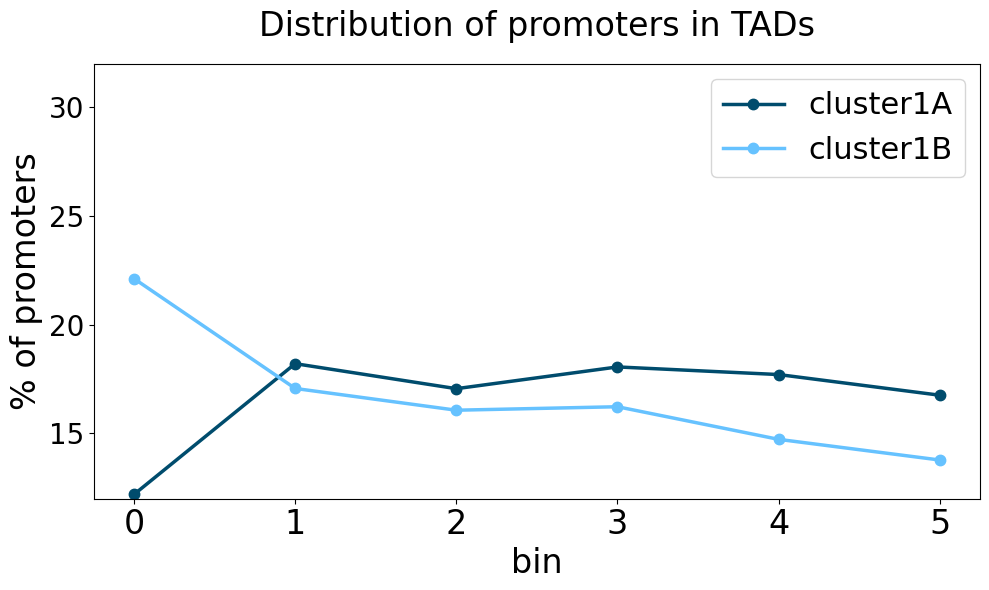

In [ ]:

def PlotBinsDistribution(df, colors, png_path):
    # Plot
    plt.figure(figsize=(10, 6))

    size = 24
    size_smaller = size - 4
    # Plot each cluster
    for index, row in df.iterrows():
        plt.plot(df.columns[2:], row[2:], marker='o', color=colors[row['Cluster']], label=row['Cluster'], linewidth=2.5, markersize=7.5)

    # Add labels and legend
    plt.xlabel('bin', fontsize = size)
    plt.ylabel('% of promoters', fontsize = size)
    plt.title('Distribution of promoters in TADs', fontsize=size,  pad=20)
    #plt.xticks(rotation=45)
    plt.legend()
    plt.ylim(12, 32)  # Adjust limits as needed
    plt.yticks([15, 20, 25, 30], fontsize=size_smaller)
    plt.xticks(fontsize=size)
    plt.legend(fontsize=size - 2)  # Increase font size of legend

    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(png_path)
    plt.show()

png_path = part1_dir + 'distribution_bins_1A_1B.png'

PlotBinsDistribution(df_observed[(df_observed['Cluster'] == 'cluster1A') | (df_observed['Cluster'] == 'cluster1B')], colors, png_path)
#PlotBinsDistribution(df_observed[df_observed['Cluster'] != 'cluster1'], colors, png_path)

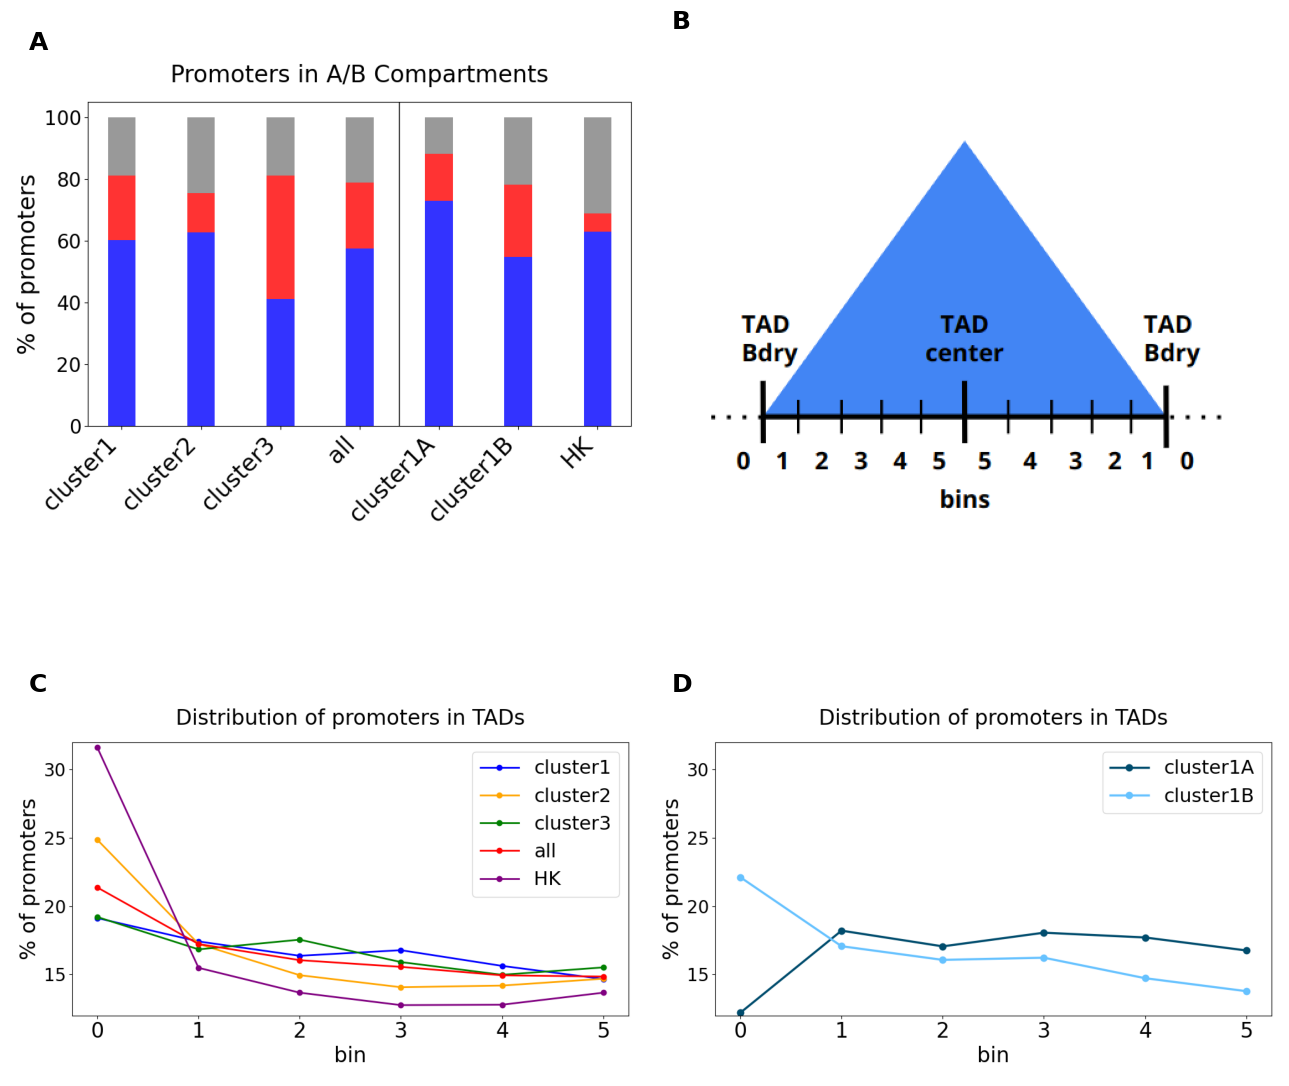

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the three images
image1 = Image.open(part1_dir + 'compartments_distribution.png')
image2 = Image.open(part1_dir + 'Alvaro_bins_adapted.png')
image3 = Image.open(part1_dir + 'distribution_bins.png')
image4 = Image.open(part1_dir + 'distribution_bins_1A_1B.png')

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(13, 13))

# Set titles for each subplot with smaller font size
axs[0, 0].set_title('A', fontsize=18, fontweight='bold', loc='left', x=0.03, y=1.0)
axs[0, 1].set_title('B', fontsize=18, fontweight='bold', loc='left', x=0.03, y=1.0)
axs[1, 0].set_title('C', fontsize=18, fontweight='bold', loc='left', x=0.03, y=1.0)
axs[1, 1].set_title('D', fontsize=18, fontweight='bold', loc='left', x=0.03, y=1.0)

# Display each image in its respective subplot
axs[0, 0].imshow(image1)
#axs[0, 0].imshow(image1)
axs[0, 1].imshow(image2)
axs[1, 0].imshow(image3)
axs[1, 1].imshow(image4)

# Hide axes
for ax in axs.flatten():
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Show the figure

**7.   Perform Chi-square test in the distribution of bins**

In [ ]:
# Distribution of promoters in the bins of TADs - REAL clusters
def CalculateBinsDistribution(promoters, cluster, df):
  #Define counts of promoters in each bin
  total_bin_counts = {f'Bin{i}': 0 for i in range(n_bins + 1)}
  for promoter in promoters:
    # Bins of promoters
    promoter_bins = [value for sublist in promoter.tads.values() for value in sublist]
    # Bins are counted once in the TAD
    unique_bins = list(set(promoter_bins))

    # Bin 0 will only count for once)
    if 'Bin0' in unique_bins:
        total_bin_counts['Bin0'] += 1
    else:
        for bin in unique_bins:
            total_bin_counts[bin] += 1
  total_bin_counts['Cluster'] = cluster
  new_row = total_bin_counts
  df.loc[len(df)] = new_row
  return df


columns = ['Cluster'] + Tad.bins
df = pd.DataFrame(columns=columns)

# Cluster1 distribution
cluster = 'cluster1'
promoters = Promoter.RetrieveClusterMembers('cluster1A') + Promoter.RetrieveClusterMembers('cluster1B')
df = CalculateBinsDistribution(promoters, cluster, df)

# Clusters 1A, 1B, 2, 3 distribution
for cluster in clusters_dict.keys():
  promoters = Promoter.RetrieveClusterMembers(cluster)
  df = CalculateBinsDistribution(promoters, cluster, df)

# 'All' promoters distribution
cluster = 'all'
promoters = Promoter.RetrieveClusterMembers(cluster)
df = CalculateBinsDistribution(promoters, cluster, df)

# HK genes distribution
cluster = 'HK'
hk_identifiers = []
with open(hk_genes_list, 'r') as file:
  for line in file:
    identifier = line.strip('\n')
    hk_identifiers.append(identifier)
hk_promoters = []
for identifier, promoter in Promoter.all_promoters.items():
  if identifier in hk_identifiers:
    hk_promoters.append(promoter)
df = CalculateBinsDistribution(hk_promoters, cluster, df)

# Make a little modification in column names
#df = df.rename(columns={col: str(i) for i, col in enumerate(df.columns[2:], start=0)})

#df_observed = df.copy()
#df_observed.to_csv(csv_path, index=False)

df

,Cluster,Bin0,Bin1,Bin2,Bin3,Bin4,Bin5
0,cluster1,1661,1512,1421,1457,1357,1274
1,cluster1A,319,476,446,472,463,438
2,cluster1B,1342,1036,975,985,894,836
3,cluster2,2013,1396,1211,1139,1149,1190
4,cluster3,786,689,718,651,613,635
5,all,4460,3597,3350,3247,3119,3099
6,HK,1045,512,452,422,423,452


In [ ]:
import pandas as pd
from itertools import combinations
from scipy.stats import chi2_contingency

# Get all combinations of pairs of groups
group_pairs = list(combinations(df['Cluster'], 2))

# Perform tests for each pair
columns = ['clusterA', 'clusterB', 'chi_statistic', 'pval']
df_pvals = pd.DataFrame(columns=columns)

for pair in group_pairs:
    group1_name, group2_name = pair
    new_row = {}
    new_row['clusterA'] = group1_name
    new_row['clusterB'] = group2_name

    group1_data = df[df['Cluster'] == group1_name].drop(columns='Cluster').values.flatten()
    group2_data = df[df['Cluster'] == group2_name].drop(columns='Cluster').values.flatten()

    # Chi-square test
    chi2_stat, p_value, _, _ = chi2_contingency([group1_data, group2_data])
    new_row['chi_statistic'] = chi2_stat
    new_row['pval'] = p_value
    df_pvals.loc[len(df_pvals)] = new_row

df_pvals

,clusterA,clusterB,chi_statistic,pval
0,cluster1,cluster1A,69.385819,1.375385e-13
1,cluster1,cluster1B,20.607049,9.608612e-04
2,cluster1,cluster2,93.977366,9.799786e-19
3,cluster1,cluster3,6.227209,2.847341e-01
4,cluster1,all,23.126135,3.193283e-04
5,cluster1,HK,220.829314,9.869930e-46
6,cluster1A,cluster1B,121.333207,1.637986e-24
7,cluster1A,cluster2,194.860489,3.569899e-40
8,cluster1A,cluster3,62.779059,3.234633e-12
9,cluster1A,all,125.101787,2.603626e-25


In [ ]:
def transform_value(value):
    if value < 0.005:
        return '***'
    elif value < 0.01:
        return '**'
    elif value < 0.05:
        return '*'
    else:
        return '.'
df_symbols = df_pvals.copy()

# Apply the function to each value in the DataFrame
df_symbols['pval'] = df_symbols['pval'].apply(transform_value)


filtered_df = df_symbols[(df_symbols['clusterA'] == 'all') | (df_symbols['clusterB'] == 'all')]
filtered_df
# cluster1B - all no significativo
# cluster 3 - all *
# cluster1, cluster2, cluster1B - all ***

,clusterA,clusterB,chi_statistic,pval
4,cluster1,all,23.126135,***
9,cluster1A,all,125.101787,***
13,cluster1B,all,6.486870,.
16,cluster2,all,47.169699,***
18,cluster3,all,13.912547,*
20,all,HK,173.182945,***


In [ ]:
#filtered_df = df[~df['Cluster'].isin(['cluster1A', 'cluster1B', 'all'])]
filtered_df = df.copy()
group_pairs = list(combinations(filtered_df['Cluster'], 2))

# Perform tests for each pair
for pair in group_pairs:
    group1_name, group2_name = pair
    group1_data = filtered_df[filtered_df['Cluster'] == group1_name].drop(columns='Cluster').values.flatten()
    group2_data = filtered_df[filtered_df['Cluster'] == group2_name].drop(columns='Cluster').values.flatten()

    # Chi-square test
    chi2_stat, p_value, _, _ = chi2_contingency([group1_data, group2_data])

    # Calculate expected counts
    expected_counts = pd.DataFrame(_)

    # Calculate residuals
    residuals = (pd.DataFrame([group1_data, group2_data]) - expected_counts) / np.sqrt(expected_counts)

    if group1_name == 'all' or group2_name == 'all':
      print(f"Comparison between {group1_name} and {group2_name}:")
#    print("Chi-square Statistic:", chi2_stat)
      print("P-value:", p_value)
      print("\nResiduals:")
      print(residuals)
      print()

      # Los residuals parecen indicar que las diferencias observdas se deben a Bin0 y luego puede haber alguno a Bins de dentro.

Comparison between cluster1 and all:
P-value: 0.00031932832861430007

Residuals:
          0         1         2         3         4         5
0 -3.234317  0.287620  0.519159  2.020743  1.160936 -0.296987
1  2.085981 -0.185501 -0.334833 -1.303284 -0.748749  0.191542

Comparison between cluster1A and all:
P-value: 2.6036259565798073e-25

Residuals:
          0         1         2         3         4         5
0 -9.231405  1.064919  1.143479  2.854437  3.221436  2.234284
1  3.266920 -0.376866 -0.404668 -1.010162 -1.140040 -0.790695

Comparison between cluster1B and all:
P-value: 0.2616823766377807

Residuals:
         0         1         2         3         4         5
0  0.97233 -0.233496  0.026640  1.029301 -0.329064 -1.690373
1 -0.52427  0.125898 -0.014364 -0.554987  0.177427  0.911430

Comparison between cluster2 and all:
P-value: 5.246395017179721e-09

Residuals:
          0         1         2         3         4         5
0  4.786386  0.008136 -1.790688 -2.485278 -1.274925 -0.2572

# **2 Determination of the features that characterize the TADs occupied by each cluster of genes.**

The following steps are included in the analysis:

1.   Categorize TADs in 3 density labels: Low Density, Medium Density and High Density
2.   Calculate the specificity parameter for each cluster in TADs
3.   Scale TAD's specificity, density and size from 0.0 to 1.0
4.   Plot boxplots for scaled specificity, density and size
5.   Perform randomization analysis for the specificity parameter.
6.   Perform t-test for the density and size parameters.

**1.   Categorize TADs in 3 density labels: Low Density, Medium Density and High Density**

In [ ]:
# Categorize TADs in DENISTY
Tad.CategorizeInDensities()

**2.   Calculate the specificity parameter for each cluster in TADs**

In [ ]:
# Calculate TAD SPÈCIFICITY for each cluster
clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
Tad.CalculateSpecificities(clusters)

**3.   Scale TAD's specificity, density and size from 0.0 to 1.0**

In [ ]:
clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
csv_path = part1_logs + 'promoters_in_tads.csv'

read_flag = True

if os.path.exists(csv_path) and read_flag:
  df_proms = pd.read_csv(csv_path)
else:
  columns = ['promoter', 'Cluster', 'TAD_identifier', 'length', 'n_promoters', 'density_val', 'density_label'] + clusters
  df_proms = pd.DataFrame(columns=columns)

  all_promoters = Promoter.all_promoters.values()
  for prom in all_promoters:
    tad = next(iter(prom.tads)) # tad_instance : ['Bin1', 'Bin2'], 'Bin0':[]'Bin0'] or tad_instance : 'Bin0'
    if tad == 'Bin0': # inter-TAD
      new_row = {'promoter' : prom.identifier,
            'Cluster' : prom.cluster,
            'TAD_identifier': 'Inter-TAD',
            'length': None,
            'n_promoters': None,
            'density_val': None,
            'density_label': None,
            'cluster1A': None,
            'cluster1B': None,
            'cluster2': None,
            'cluster3': None}
    else: # tad_instance : 'Bin0' is considered as to be in that tad
      new_row = {'promoter' : prom.identifier,
                'Cluster' : prom.cluster,
                'TAD_identifier': tad.identifier,
                'length': tad.length,
                'n_promoters': len(tad.RetrievePromoters()),
                'density_val': tad.promoters_density[0],
                'density_label': tad.promoters_density[1],
                'cluster1A': tad.specificity['cluster1A'],
                'cluster1B': tad.specificity['cluster1B'],
                'cluster2': tad.specificity['cluster2'],
                'cluster3': tad.specificity['cluster3']}

    df_proms.loc[len(df_proms)] = new_row
  df_proms.to_csv(csv_path, index=False)
df_proms

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1A,cluster1B,cluster2,cluster3
0,Xkr4,cluster1A,TAD0-4328000,4.328000,1.0,0.231054,LD,1.000000,0.000000,0.000000,0.000000
1,Fam150a,cluster1A,TAD5089000-6980000,1.891000,5.0,2.644104,LD,0.200000,0.600000,0.200000,0.000000
2,Sntg1,cluster1A,TAD7003000-9437000,2.434000,2.0,0.821693,LD,0.500000,0.000000,0.000000,0.500000
3,Sgk3,cluster1A,TAD9559000-10112000,0.553000,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
4,Tcf24,cluster1A,TAD9559000-10112000,0.553000,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
...,...,...,...,...,...,...,...,...,...,...,...
20614,Ssty2,cluster3,TAD9905000-91744698,81.839698,21.0,0.256599,LD,0.000000,0.047619,0.380952,0.571429
20615,Gm20816,cluster3,TAD9905000-91744698,81.839698,21.0,0.256599,LD,0.000000,0.047619,0.380952,0.571429
20616,Gm20806,cluster3,TAD9905000-91744698,81.839698,21.0,0.256599,LD,0.000000,0.047619,0.380952,0.571429
20617,Gm20917,cluster3,TAD9905000-91744698,81.839698,21.0,0.256599,LD,0.000000,0.047619,0.380952,0.571429


In [ ]:
# Delete promoters not in TADs
df_proms = df_proms[df_proms['TAD_identifier'] != 'Inter-TAD']
df_proms

# Delete a huge TAD
df_proms = df_proms[df_proms['length'] < 8]
df_proms

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1A,cluster1B,cluster2,cluster3
0,Xkr4,cluster1A,TAD0-4328000,4.328,1.0,0.231054,LD,1.000000,0.000000,0.000000,0.000000
1,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.200000,0.600000,0.200000,0.000000
2,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.500000,0.000000,0.000000,0.500000
3,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
4,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
...,...,...,...,...,...,...,...,...,...,...,...
20602,Gm6026,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20603,Sry,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20604,Gm16501,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20605,Gm20826,cluster3,TAD6792000-9788000,2.996,2.0,0.667557,LD,0.000000,0.000000,0.000000,1.000000


In [ ]:
cluster_counts = df_proms['Cluster'].value_counts()
print(cluster_counts)

Cluster
cluster2     6001
cluster1B    4655
cluster3     3240
cluster1A    2270
Name: count, dtype: int64


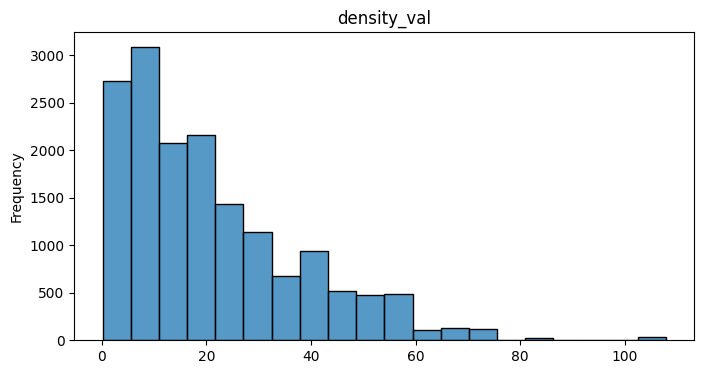

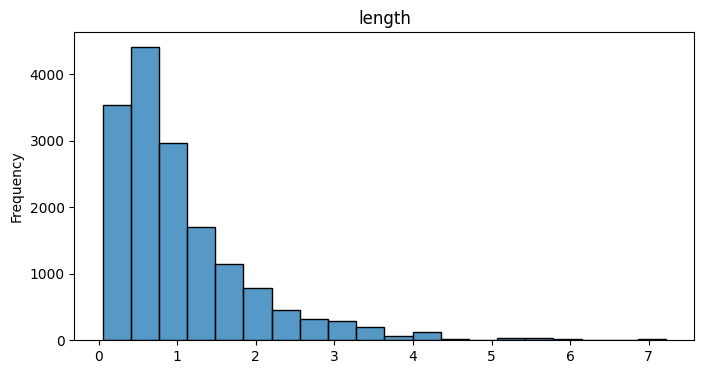

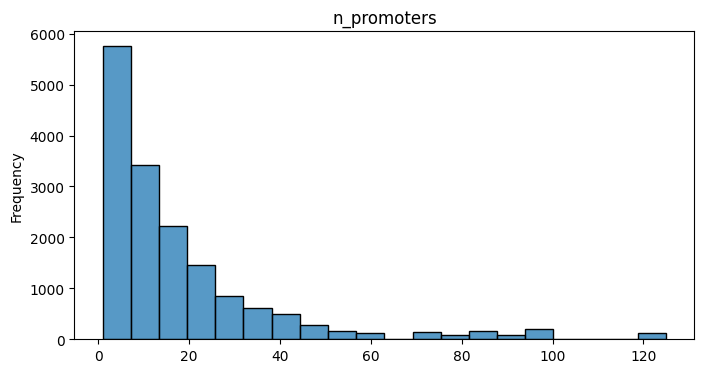

In [ ]:
# Distribution of values: length, n_promoters and density
columns = ['density_val', 'length', 'n_promoters']
for column in columns:
  plt.figure(figsize=(8, 4))
  sns.histplot(data=df_proms, x=column, bins=20, kde=False)
  plt.title(f'{column}')
  plt.xlabel('')
  plt.ylabel('Frequency')
  plt.show()

In [ ]:
# Delete TADs with length lower than 4.000 kb: 300 rows lost
df_proms = df_proms[df_proms['length'] < 3.5]

# Delete TADs with density val lower than 0.00006
df_proms = df_proms[df_proms['density_val'] < 70]

df_proms

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1A,cluster1B,cluster2,cluster3
1,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.200000,0.600000,0.200000,0.000000
2,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.500000,0.000000,0.000000,0.500000
3,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
4,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111
6,Slco5a1,cluster1A,TAD12862000-13656000,0.794,4.0,5.037783,MD,0.250000,0.250000,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20602,Gm6026,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20603,Sry,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20604,Gm16501,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769
20605,Gm20826,cluster3,TAD6792000-9788000,2.996,2.0,0.667557,LD,0.000000,0.000000,0.000000,1.000000


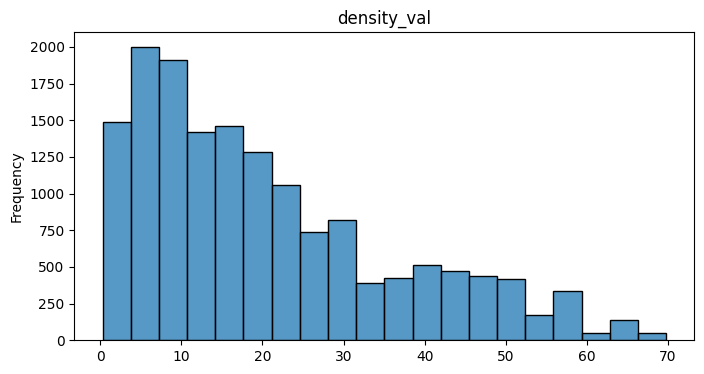

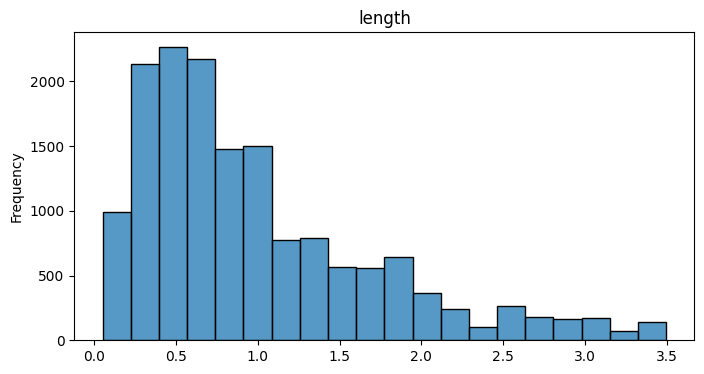

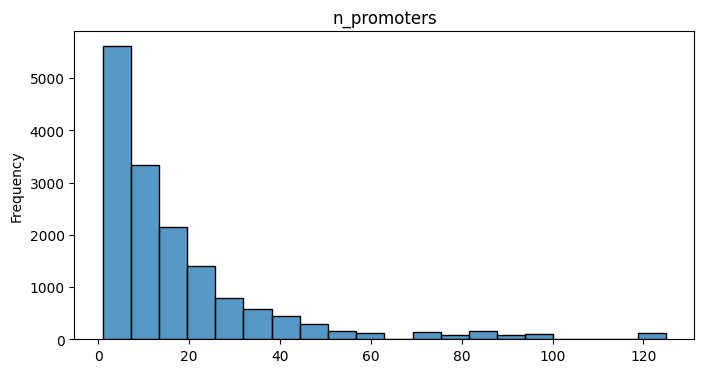

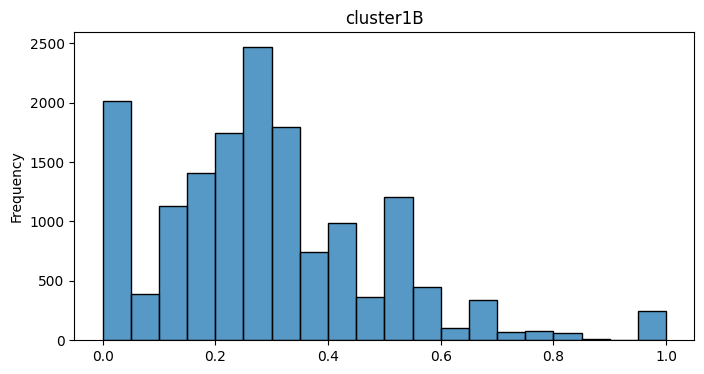

In [ ]:
# Distribution of values: length, n_promoters and density
columns = ['density_val', 'length', 'n_promoters', 'cluster1B']
for column in columns:
  plt.figure(figsize=(8, 4))
  sns.histplot(data=df_proms, x=column, bins=20, kde=False)
  plt.title(f'{column}')
  plt.xlabel('')
  plt.ylabel('Frequency')
  plt.show()

In [ ]:
cluster_counts = df_proms['Cluster'].value_counts()
print(cluster_counts)

Cluster
cluster2     5824
cluster1B    4486
cluster3     3087
cluster1A    2199
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0.0, 1.0))

# Fit and transform the 'density_val' and 'length' columns
df_proms['scaled_density_val'] = scaler.fit_transform(df_proms[['density_val']])
df_proms['scaled_length'] = scaler.fit_transform(df_proms[['length']])
df_proms

,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1A,cluster1B,cluster2,cluster3,scaled_density_val,scaled_length
1,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.200000,0.600000,0.200000,0.000000,0.033886,0.533798
2,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.500000,0.000000,0.000000,0.500000,0.007656,0.691326
3,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111,0.230075,0.145634
4,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.222222,0.555556,0.111111,0.111111,0.230075,0.145634
6,Slco5a1,cluster1A,TAD12862000-13656000,0.794,4.0,5.037783,MD,0.250000,0.250000,0.500000,0.000000,0.068339,0.215550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20602,Gm6026,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769,0.076446,0.658544
20603,Sry,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769,0.076446,0.658544
20604,Gm16501,cluster3,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.000000,0.692308,0.076923,0.230769,0.076446,0.658544
20605,Gm20826,cluster3,TAD6792000-9788000,2.996,2.0,0.667557,LD,0.000000,0.000000,0.000000,1.000000,0.005438,0.854366


In [ ]:
# Add Cluster 'all'
df_duplicated = df_proms.copy()
df_duplicated['Cluster'] = 'all'
df_combined = pd.concat([df_proms, df_duplicated], ignore_index=True)

# Add new column 'cluster1' for specificity with value 0.0
df_combined['cluster1'] = 0.0

# Add Cluster 'cluster1'
filtered_df = df_combined.loc[(df_combined['Cluster'] == 'cluster1A') | (df_combined['Cluster'] == 'cluster1B')]
# Add new column 'cluster1' for specificity with values of cluster1A + cluster1B
filtered_df['cluster1'] = filtered_df['cluster1A'] + filtered_df['cluster1B']
filtered_df['Cluster'] = 'cluster1'

# Merge to have the final df
df_proms_final = pd.concat([df_combined, filtered_df], ignore_index=True)
# Reorder columns
df_proms_final = df_proms_final[['promoter', 'Cluster', 'TAD_identifier', 'length', 'n_promoters', 'density_val', 'density_label',
                             'cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B', 'scaled_density_val', 'scaled_length']]

# Add new column with the specificity of the promoter's cluster
df_proms_final['cluster_specificity'] = 0.0
for index, row in df_proms_final.iterrows():
    cluster_value = row['Cluster']
    if cluster_value == 'all':
      continue
    cluster_specificity_value = row[cluster_value]
    df_proms_final.at[index, 'cluster_specificity'] = cluster_specificity_value

# Add column for n_promoters lower than a value
conditions = [
    df_proms_final['n_promoters'] < 5,
    df_proms_final['n_promoters'] < 10,
    df_proms_final['n_promoters'] < 15,
    df_proms_final['n_promoters'] < 20,
    df_proms_final['n_promoters'] < 25
]
values = ['<5', '<10', '<15', '<20', '<25']
df_proms_final['promoter_range'] = np.select(conditions, values, default='>=25')

df_proms_final

<ipython-input-40-42fe4127e865>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cluster1'] = filtered_df['cluster1A'] + filtered_df['cluster1B']
<ipython-input-40-42fe4127e865>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Cluster'] = 'cluster1'


,promoter,Cluster,TAD_identifier,length,n_promoters,density_val,density_label,cluster1,cluster2,cluster3,cluster1A,cluster1B,scaled_density_val,scaled_length,cluster_specificity,promoter_range
0,Fam150a,cluster1A,TAD5089000-6980000,1.891,5.0,2.644104,LD,0.000000,0.200000,0.000000,0.200000,0.600000,0.033886,0.533798,0.200000,<10
1,Sntg1,cluster1A,TAD7003000-9437000,2.434,2.0,0.821693,LD,0.000000,0.000000,0.500000,0.500000,0.000000,0.007656,0.691326,0.500000,<5
2,Sgk3,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
3,Tcf24,cluster1A,TAD9559000-10112000,0.553,9.0,16.274864,HD,0.000000,0.111111,0.111111,0.222222,0.555556,0.230075,0.145634,0.222222,<10
4,Slco5a1,cluster1A,TAD12862000-13656000,0.794,4.0,5.037783,MD,0.000000,0.500000,0.000000,0.250000,0.250000,0.068339,0.215550,0.250000,<5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37872,Gm21677,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37873,Gm21693,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37874,Gm21704,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15
37875,Gm21708,cluster1,TAD1749000-4070000,2.321,13.0,5.601034,MD,0.692308,0.076923,0.230769,0.000000,0.692308,0.076446,0.658544,0.692308,<15


**4.   Plot boxplots for scaled specificity, density and size**

<ipython-input-46-e75df4d0b383>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proms_final, x='Cluster', y='scaled_density_val', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,


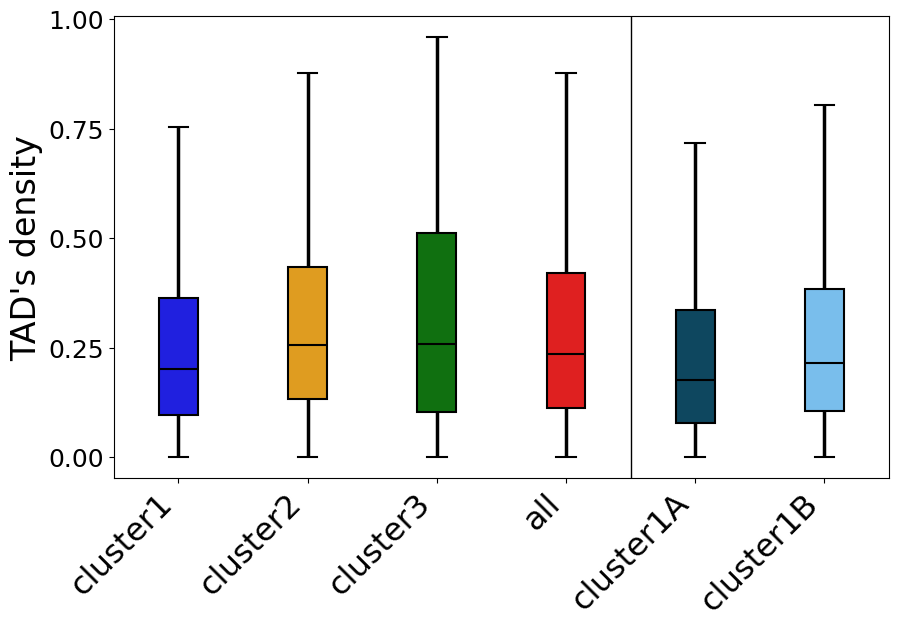

In [ ]:
# Path to save the plot
png_path = part1_dir + 'density.png'

# Define order of clusters
order = ['cluster1', 'cluster2', 'cluster3', 'all', 'cluster1A', 'cluster1B']

# Define color palette for clusters
cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red', 'HK': 'purple'}

# Set the size for labels and ticks
size = 24
smaller_size = size - 6

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_proms_final, x='Cluster', y='scaled_density_val', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,
            boxprops=dict(edgecolor='black'), whiskerprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='white', linewidth=1.5),  # Set median line color to white
            meanprops=dict(marker='o', markerfacecolor='white', markeredgecolor='white', markersize=10),
            showfliers=False, order=order)

# Add a vertical line as separator before 'cluster1A'
plt.axvline(x=order.index('cluster1A') - 0.5, color='black', linestyle='-', linewidth=1.0)
# Remove x-label
plt.xlabel('')

# Set y-label
plt.ylabel("TAD's density", fontsize=size)

# Set y-tick labels
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=smaller_size)

# Set x-tick labels
plt.xticks(rotation=45, ha='right', fontsize=size-1)


# Manually adjust whiskers
for line in plt.gca().lines:
    if line.get_linestyle() == '-':  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity

# Save and show the plot
plt.savefig(png_path, bbox_inches='tight')  # Use bbox_inches='tight' to include legend properly
plt.show()


<ipython-input-48-1f3dd673d32b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proms_final, x='Cluster', y='cluster_specificity', linewidth=1.5, width=0.3,


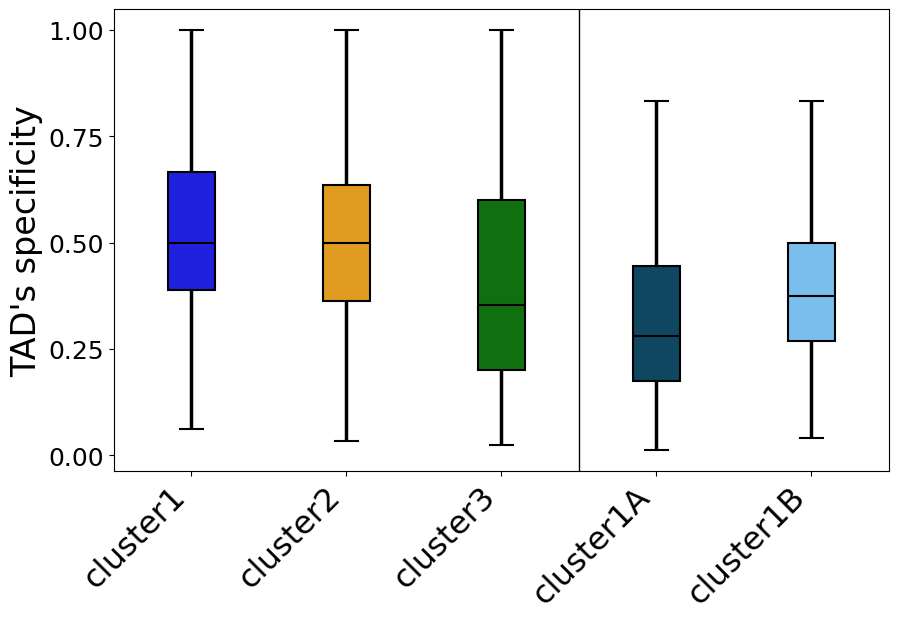

In [ ]:

order = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B']
png_path = part1_dir + 'specificity.png'

size = 24
smaller_size = size - 6

# Define a color palette for each cluster
cluster_palette = {'cluster1' : 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all' : 'red', 'HK' : 'purple'}

plt.figure(figsize=(10, 6))

# Plot boxplot with different colors for each cluster
sns.boxplot(data=df_proms_final, x='Cluster', y='cluster_specificity', linewidth=1.5, width=0.3,
            palette=cluster_palette, boxprops=dict(edgecolor='black'), whiskerprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='black', linewidth=1.5), meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=10),
            showfliers=False, order=order)

# Add horizontal lines
#plt.axhline(y=0.25, color='gray', linestyle='--', linewidth=0.75)
#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.75)
#plt.axhline(y=0.75, color='gray', linestyle='--', linewidth=0.75)
# Add a vertical line as separator before 'cluster1A'
plt.axvline(x=order.index('cluster1A') - 0.5, color='black', linestyle='-', linewidth=1.0)
plt.xlabel('')
plt.ylabel('TAD\'s specificity', fontsize=size)
#plt.title('Specificity')
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=smaller_size)  # Specify the positions of the y-ticks
plt.xticks(rotation=45, ha='right', fontsize=size - 1)

# Manually adjust whiskers
for line in plt.gca().lines:
    if (line.get_linestyle() == '-'):  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity

plt.savefig(png_path, bbox_inches='tight')  # Use bbox_inches='tight' to include legend properly
plt.show()


<ipython-input-49-3bbaf702b342>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proms_final, x='Cluster', y='scaled_length', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,


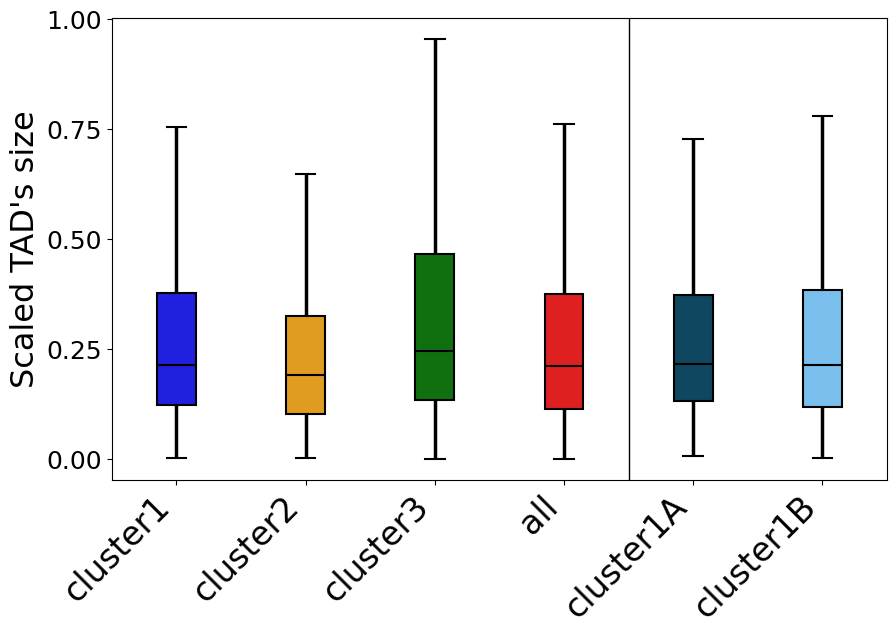

In [ ]:
order = ['cluster1', 'cluster2', 'cluster3', 'all', 'cluster1A', 'cluster1B']
png_path = part1_dir + 'length.png'
cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red', 'HK': 'purple'}

size = 24
smaller_size = size - 6

plt.figure(figsize=(10, 6))

sns.boxplot(data=df_proms_final, x='Cluster', y='scaled_length', color='white', linewidth=1.5, width=0.3, palette=cluster_palette,
            boxprops=dict(edgecolor='black'), whiskerprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='black', linewidth=1.5), meanprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=10)
            , showfliers=False, order=order)

# Add horizontal lines
#plt.axhline(y=0.25, color='gray', linestyle='--', linewidth=0.75)
#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.75)
#plt.axhline(y=0.75, color='gray', linestyle='--', linewidth=0.75)
plt.axvline(x=order.index('cluster1A') - 0.5, color='black', linestyle='-', linewidth=1.0)

plt.xlabel('')
plt.ylabel('Scaled TAD\'s size', fontsize = size - 1)
#plt.title('Size', fontsize = 12)

plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=smaller_size)  # Specify the positions of the y-ticks
plt.xticks(rotation=45, ha='right', fontsize=size)

#plt.ylim(0, 1)  # Adjust the limits as needed

# Manually adjust whiskers
for line in plt.gca().lines:
    if (line.get_linestyle() == '-'):  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity

plt.savefig(png_path, bbox_inches='tight')  # Use bbox_inches='tight' to include legend properly
plt.show()

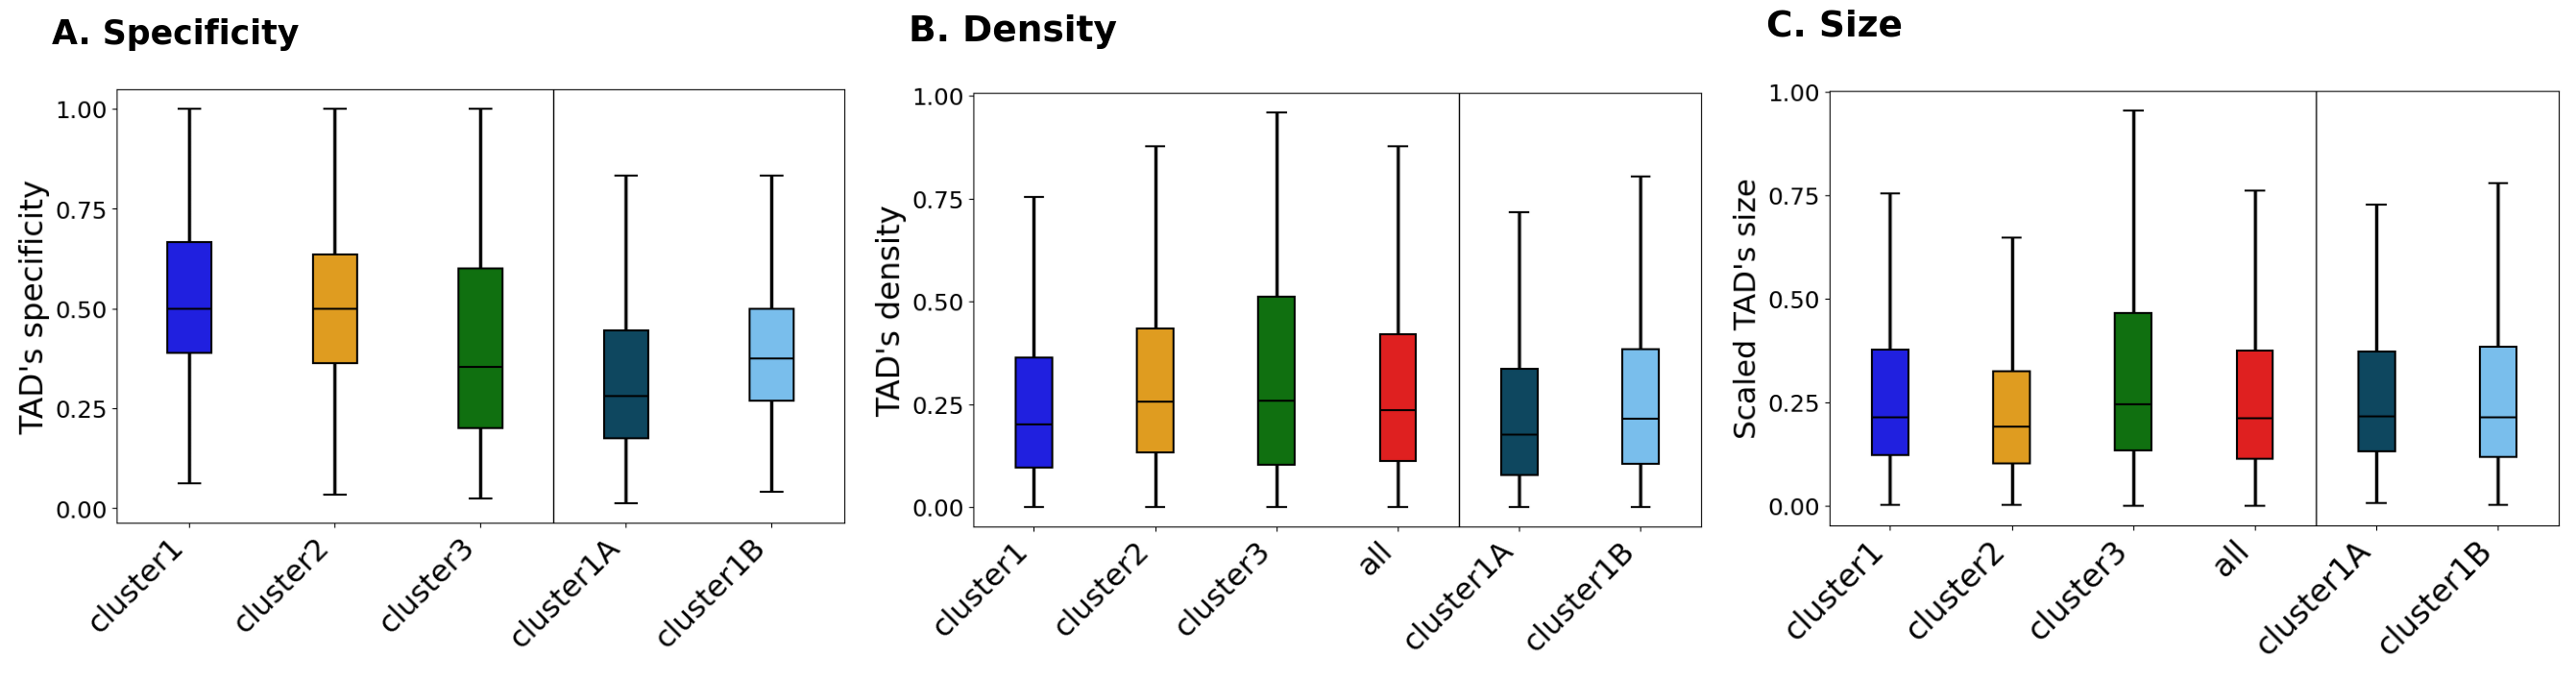

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the three images
image1 = Image.open(part1_dir + 'specificity.png')
image2 = Image.open(part1_dir + 'density.png')
image3 = Image.open(part1_dir + 'length.png')

# Create a figure with 2x2 subplots
#aspect_ratios = [image1.width / image1.height, image2.width / image2.height, image3.width / image3.height]

total_width = image1.width + image2.width + image3.width
figsize = (total_width / 100, total_width / 300)

#figsize_width = 15
#figsize_height = figsize_width / sum(aspect_ratios)
#figsize = (figsize_width, figsize_height)

#figsize=(15, 10)
# Create a figure with 1x3 subplots
#fig, axs = plt.subplots(1, 3, figsize=figsize)
fig, axs = plt.subplots(1, 3, figsize=figsize)

# Set titles for each subplot with smaller font size
axs[0].set_title('A. Specificity', fontsize=25, fontweight='bold', loc='left', x=0.05, y=1.05)
axs[1].set_title('B. Density', fontsize=27, fontweight='bold', loc='left', x=0.05, y=1.05)
axs[2].set_title('C. Size', fontsize=27, fontweight='bold', loc='left', x=0.05, y=1.05)

# Display each image in its respective subplot
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)

# Hide axes
for ax in axs.flatten():
    ax.axis('off')

#plt.subplots_adjust(wspace=0.05)  # Adjust wspace as needed

# Adjust layout
plt.tight_layout()

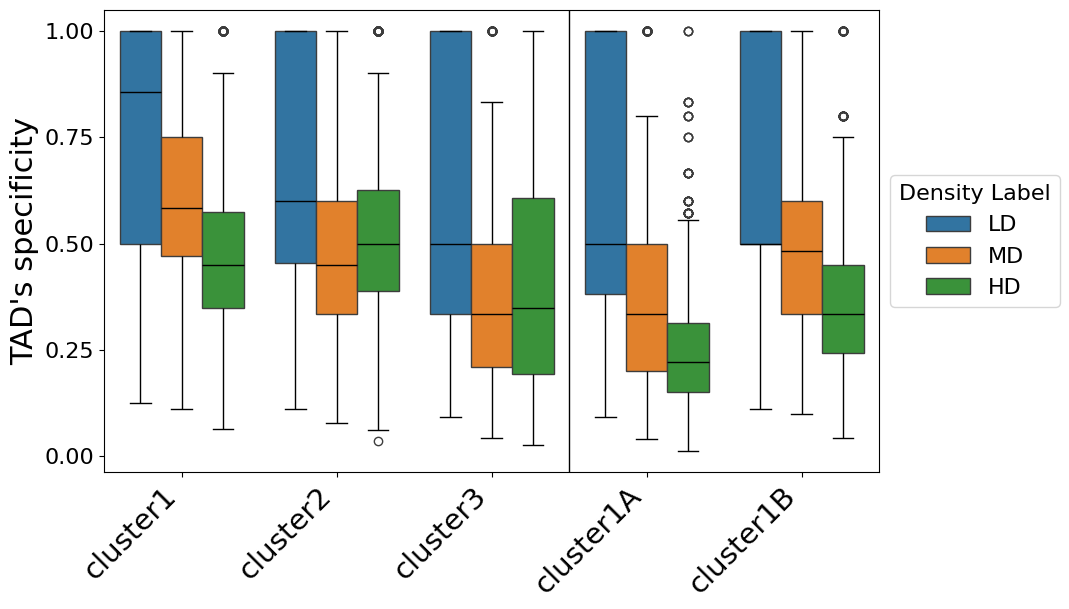

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define order and colors
order = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B']
colours = {'LD': 'blue', 'MD': 'orange', 'HD': 'green'}
colours = {'LD': '#1f77b4', 'MD': '#ff7f0e', 'HD': '#2ca02c'}

#color=['#1f77b4', '#ff7f0e', '#2ca02c'])
size = 22
smaller_size = size - 6

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot boxplot
sns.boxplot(data=df_proms_final, x='Cluster', y='cluster_specificity', hue='density_label',
            palette=colours, hue_order=['LD', 'MD', 'HD'], order=order, ax=ax)


# Set labels and title
ax.set_ylabel('TAD\'s specificity', fontsize=size)
ax.set_xlabel('')

# Manually adjust whiskers
for line in ax.lines:
    if line.get_linestyle() == '-':  # Ensure it's a solid line
        line.set_color('black')
        line.set_alpha(1.0)  # Ensure full opacity

plt.axvline(x=order.index('cluster1A') - 0.5, color='black', linestyle='-', linewidth=1.0)

# Set y-tick labels
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=smaller_size)
# Set x-tick labels
plt.xticks(rotation=45, ha='right', fontsize=size-1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Density Label', fontsize=smaller_size, title_fontsize= smaller_size)

# Hide the legend
#ax.get_legend().remove()


plt.show()


**5.   Perform randomization analysis for the specificity parameter.**

In [ ]:
def SpecificityRandomizationTest(df):

  for permutation in range(n_permutations):

    if permutation == 0:
      permutation = 'observed'
    else:
      Promoter.CreateRandomClusters(cluster_sizes)

    Tad.CalculateSpecificities(clusters)
    new_row = {cluster: 0 for cluster in clusters}
    new_row['permutation'] = permutation
    for cluster in clusters:
      cluster_vals = []
      cluster_promoters = Promoter.RetrieveClusterMembers(cluster)
      for prom in cluster_promoters:
        # Get tad of that promoter
        tad = next(iter(prom.tads))
        if tad == 'Bin0': # inter-TAD
          continue
        else:
          # Get specificity for the cluster
          val = float(tad.specificity[cluster])
          cluster_vals.append(val)
      mean = np.mean(cluster_vals)
      new_row[cluster] = mean

    df.loc[len(df)] = new_row
  return df

def CalculatePvalues(df_permuted, df_pvalues):

  new_row = {key : 0 for key in columns}

  for column in df_permuted.columns[1:]:

    observed_value = df_permuted.loc[df_permuted['permutation'] == 'observed', column].values[0]
    permuted_data = df_permuted.loc[df_permuted['permutation'] != 'observed', column].values

    mu, std = np.mean(permuted_data), np.std(permuted_data)
    normal_dist = norm(loc=mu, scale=std)

    # Kolmogorov-Smirnov test for goodness of fit of our data to a normal distributionn
    statistic, p_value = kstest(permuted_data, normal_dist.cdf)

    #If the p-value is high (e.g., greater than 0.05), it suggests that the data is likely to be drawn from the normal distribution.
    if p_value < 0.05:
      print("Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data:", cluster, column, statistic, p_value)

    # Once we know that it follows a normal distribution, we calculate probability of the observed value
    pdf_at_obs = normal_dist.pdf(observed_value) # p-value or probability of finding the value in the random distribution

    print(pdf_at_obs)
    #pdf_at_obs_formatted = "{:.10f}".format(pdf_at_obs)
    new_row[column] = pdf_at_obs

  df_pvalues.loc[len(df_pvalues)] = new_row
  return df_pvalues

In [ ]:
# Randomization for TAD specificity parameter
n_permutations = 1000
read_flag = True
# Perform for cluster1A, cluster1B, cluster2, cluster3
csv_path = part1_logs + 'specificity_permuted_c1A1B.csv'

if os.path.exists(csv_path) and read_flag:
    df_c1A1B = pd.read_csv(csv_path)
else:
  cluster_sizes = {'cluster1A': 2581, 'cluster1B': 6001, 'cluster2': 7988, 'cluster3': 4049}
  clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
  columns = ['permutation'] + clusters
  df_c1A1B = pd.DataFrame(columns=columns)

  Promoter.SetOriginalClusters('cluster1AB')

  df_c1A1B = SpecificityRandomizationTest(df_c1A1B)
  df_c1A1B.to_csv(csv_path, index=False)

# Perform for cluster1, cluster2, cluster3
csv_path = part1_logs + 'specificity_permuted_c1.csv'

if os.path.exists(csv_path) and read_flag:
    df_c1 = pd.read_csv(csv_path)
else:
  cluster_sizes = {'cluster1': 8582, 'cluster2': 7988, 'cluster3': 4049}
  clusters = ['cluster1', 'cluster2', 'cluster3']
  columns = ['permutation'] + clusters
  df_c1 = pd.DataFrame(columns=columns)

  Promoter.SetOriginalClusters('cluster1')

  df_c1 = SpecificityRandomizationTest(df_c1)
  df_c1.to_csv(csv_path, index=False)

In [ ]:
# Calculate p_values

read_flag = False

# Perform for cluster1A, cluster1B, cluster2, cluster3
csv_path = part1_logs + 'specificity_pvalues_c1A1B.csv'

if os.path.exists(csv_path) and read_flag:
    df_pvalues_c1A1B = pd.read_csv(csv_path)
else:
  clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
  columns = clusters
  df_pvalues_c1A1B = pd.DataFrame(columns=columns)
  df_pvalues_c1A1B = CalculatePvalues(df_c1A1B, df_pvalues_c1A1B)
  df_pvalues_c1A1B.to_csv(csv_path, index=False)

# Perform for cluster1, cluster2, cluster3
csv_path = part1_logs + 'specificity_pvalues_c1.csv'

if os.path.exists(csv_path) and read_flag:
    df_pvalues_c1 = pd.read_csv(csv_path)
else:
  clusters = ['cluster1', 'cluster2', 'cluster3']
  columns = clusters
  df_pvalues_c1 = pd.DataFrame(columns=columns)
  df_pvalues_c1 = CalculatePvalues(df_c1, df_pvalues_c1)
  df_pvalues_c1.to_csv(csv_path, index=False)

In [ ]:
df_pvalues_c1A1B

,cluster1A,cluster1B,cluster2,cluster3
0,4.693913e-102,1.937071e-10,2.319736e-23,2.124613e-157


In [ ]:
df_pvalues_c1

,cluster1,cluster2,cluster3
0,1.252346e-63,1.440152e-25,1.394415e-159


**6.   Perform t-test for the density and size parameters.**

In [ ]:
from scipy.stats import ttest_ind

column = 'density_val'
clusters = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B', 'all']

p_values_df = pd.DataFrame(index=clusters, columns=clusters)

for i in range(len(clusters)):
    for j in range(i+1, len(clusters)):
        cluster1 = clusters[i]
        cluster2 = clusters[j]
        data1 = df_proms_final[df_proms_final['Cluster'] == cluster1][column]
        data2 = df_proms_final[df_proms_final['Cluster'] == cluster2][column]
        t_statistic, p_value = ttest_ind(data1, data2)

        # Set a threshold for significance
        threshold = 0.05
        if p_value < threshold:
            p_values_df.at[cluster1, cluster2] = f"{p_value:.2e}"
            p_values_df.at[cluster2, cluster1] = f"{p_value:.2e}"
        else:
            p_values_df.at[cluster1, cluster2] = 'Not Significant'
            p_values_df.at[cluster2, cluster1] = 'Not Significant'

p_values_df

,cluster1,cluster2,cluster3,cluster1A,cluster1B,all
cluster1,NaN,2.48e-36,1.63e-28,2.77e-05,9.17e-03,2.48e-19
cluster2,2.48e-36,NaN,Not Significant,1.02e-38,9.87e-19,3.33e-09
cluster3,1.63e-28,Not Significant,NaN,1.38e-32,3.69e-16,2.44e-08
cluster1A,2.77e-05,1.02e-38,1.38e-32,NaN,3.90e-09,4.79e-24
cluster1B,9.17e-03,9.87e-19,3.69e-16,3.90e-09,NaN,1.25e-06
all,2.48e-19,3.33e-09,2.44e-08,4.79e-24,1.25e-06,NaN


In [ ]:
column = 'length'
clusters = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B', 'all']

p_values_df = pd.DataFrame(index=clusters, columns=clusters)

for i in range(len(clusters)):
    for j in range(i+1, len(clusters)):
        cluster1 = clusters[i]
        cluster2 = clusters[j]
        data1 = df_proms_final[df_proms_final['Cluster'] == cluster1][column]
        data2 = df_proms_final[df_proms_final['Cluster'] == cluster2][column]
        t_statistic, p_value = ttest_ind(data1, data2)
        p_values_df.at[cluster1, cluster2] = p_value #f"{p_value:.2e}"

p_values_df

,cluster1,cluster2,cluster3,cluster1A,cluster1B,all
cluster1,NaN,0.0,0.0,0.941864,0.964158,0.071218
cluster2,NaN,NaN,0.0,0.0,0.0,0.0
cluster3,NaN,NaN,NaN,0.0,0.0,0.0
cluster1A,NaN,NaN,NaN,NaN,0.918864,0.21474
cluster1B,NaN,NaN,NaN,NaN,NaN,0.133522
all,NaN,NaN,NaN,NaN,NaN,NaN
